# Quantim Walk Operator

In this assignment, we implement the quantum walk operator for the case of a line with 16 nodes using classiq. 

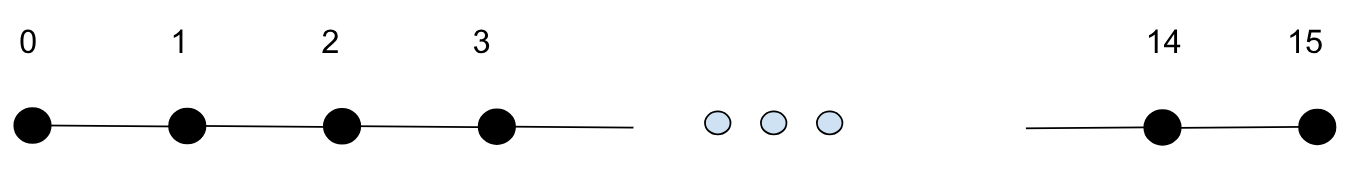

If we represent a vertix with the ket $\ket j$ and and edge connecting the vertices $(j, k)$ by $\ket{j, k}$, then
one step of the discrete-time quantum walk is descriped by the unitary operator $SC$, where 
$$S := \sum_{(j,k) \in E} \ket{j,k}\bra{k,j}$$ 
$$C := \sum_{j \in V} \ket{j}\bra{j} \otimes \left( 2 \ket{\partial_j}\bra{\partial_j} - I \right),$$ 
$$\ket{\partial_j} := \frac{1}{\sqrt{\deg(j)}} \sum_{k : (j,k) \in E} \ket{k}.$$ 
Since in this example we have 16 vertices, we will utalize $\log_2(16) = 4$ qubits

### The $C$ Operator

Let's begin by implementing the operator $C$. First, note that due to the outer product $\ket j \bra j$ ,
$$C \ket{x, k} = 0 \; \forall x \neq j$$
The action of $C$ should thus be controlled on the first ket being in state $\ket j$, as we will explicity code later.

Second, note that $\left( 2 \ket{\partial_j}\bra{\partial_j} - I \right) = M_j \left( 2 \ket{0}\bra{0} - I \right) M_j^{-1} $, where $M_j\ket 0  = \ket{\partial_j}$. We could thus sandwich the `zero_diffuzer` operator $\left( 2 \ket{0}\bra{0} - I \right)$ between $M_j$ and $M_j^{-1}$ using the `within_apply` classiq operation.

We begin our code by importing the classiq SDK package

In [2]:
from classiq import *

Next we implement the `zero_diffuzer` operator

In [3]:
size = 4 # Number of qubits

@qfunc 
def prepare_minus(x: QBit): # Prepares |-> for Phase Kickback
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum): # Oracle for the fucntion f(x) = 1 if x != |0> and 0 otherwise
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum): # Implements 2|x><x| - I
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

Now, the (non-Unitary) operator $M_j$ is going to be implemented via `inplace_prepare_state`, where the state to be prepared is $\ket{\partial_j}$, specified via its definition given at the top.

In [4]:
def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum): # Implements one term of the sum of C
    
    prob = [ 0 for i in range(2**size) ]

    # Inintalizing the probabilities of |\partial_j>
    if i == 0:
       prob[i+1] = 1
    elif i == (2**size -1):
       prob[i-1] = 1
    else:
      prob[i+1]=0.5
      prob[i-1]=0.5

    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size): # Implement the sum in the operator C
      C_iteration(i,vertices,adjacent_vertices)

### The $S$ Operator

The action of $S$ is much simpler:
$$
S \ket{x, y} =  \begin{cases} 
\ket{y, x} & \text{if} \; (x, y) \in E \\
0 & \text{otherwise}.
\end{cases}
$$
So all we need to do to implement $S$ is to design an oracle to test whether or not $(x, y)$ is a valid edge, and if the oracle returns true we perform a bitwise swap.

In [5]:
# Oracle to test if given ket is a valid edge
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

# Swaps x and y
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]): 
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  
# Swaps x and y if (x, y) is a valid edge
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))


## Results

Now we can put everything together in a `main` fuction that executes one step of the discrete quantum walk.

In [6]:
# Executes one step of the discrete quantum walk.
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices) # Initialize vertices to |0>
  hadamard_transform(vertices) # Transform into eq. superposition of all states
  allocate(size,adjacent_vertices) # Initialize adj_vertices to |0>

  C_operator(vertices,adjacent_vertices) # Apply the C operator
  S_operator(vertices,adjacent_vertices) # Apply the S operator

qmod = create_model(main) # Creating the Quantum Model
qprog = synthesize(qmod) # Feeding the Model to the Synthesis Engine
show(qprog) # Displaying the resulting circuit on the Classiq platform

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

The synthesis engine produces the follwing circuit, with a Depth of 3068 gates and Width 37 qubits. This is the highest level of abstraction, any deeper would of course produce too wide of an image. expanding the `C_Operator` block, for example, exposes a 16-time repeating layer of applying the controlled $\left( 2 \ket{\partial_j}\bra{\partial_j} - I \right)$ operator.

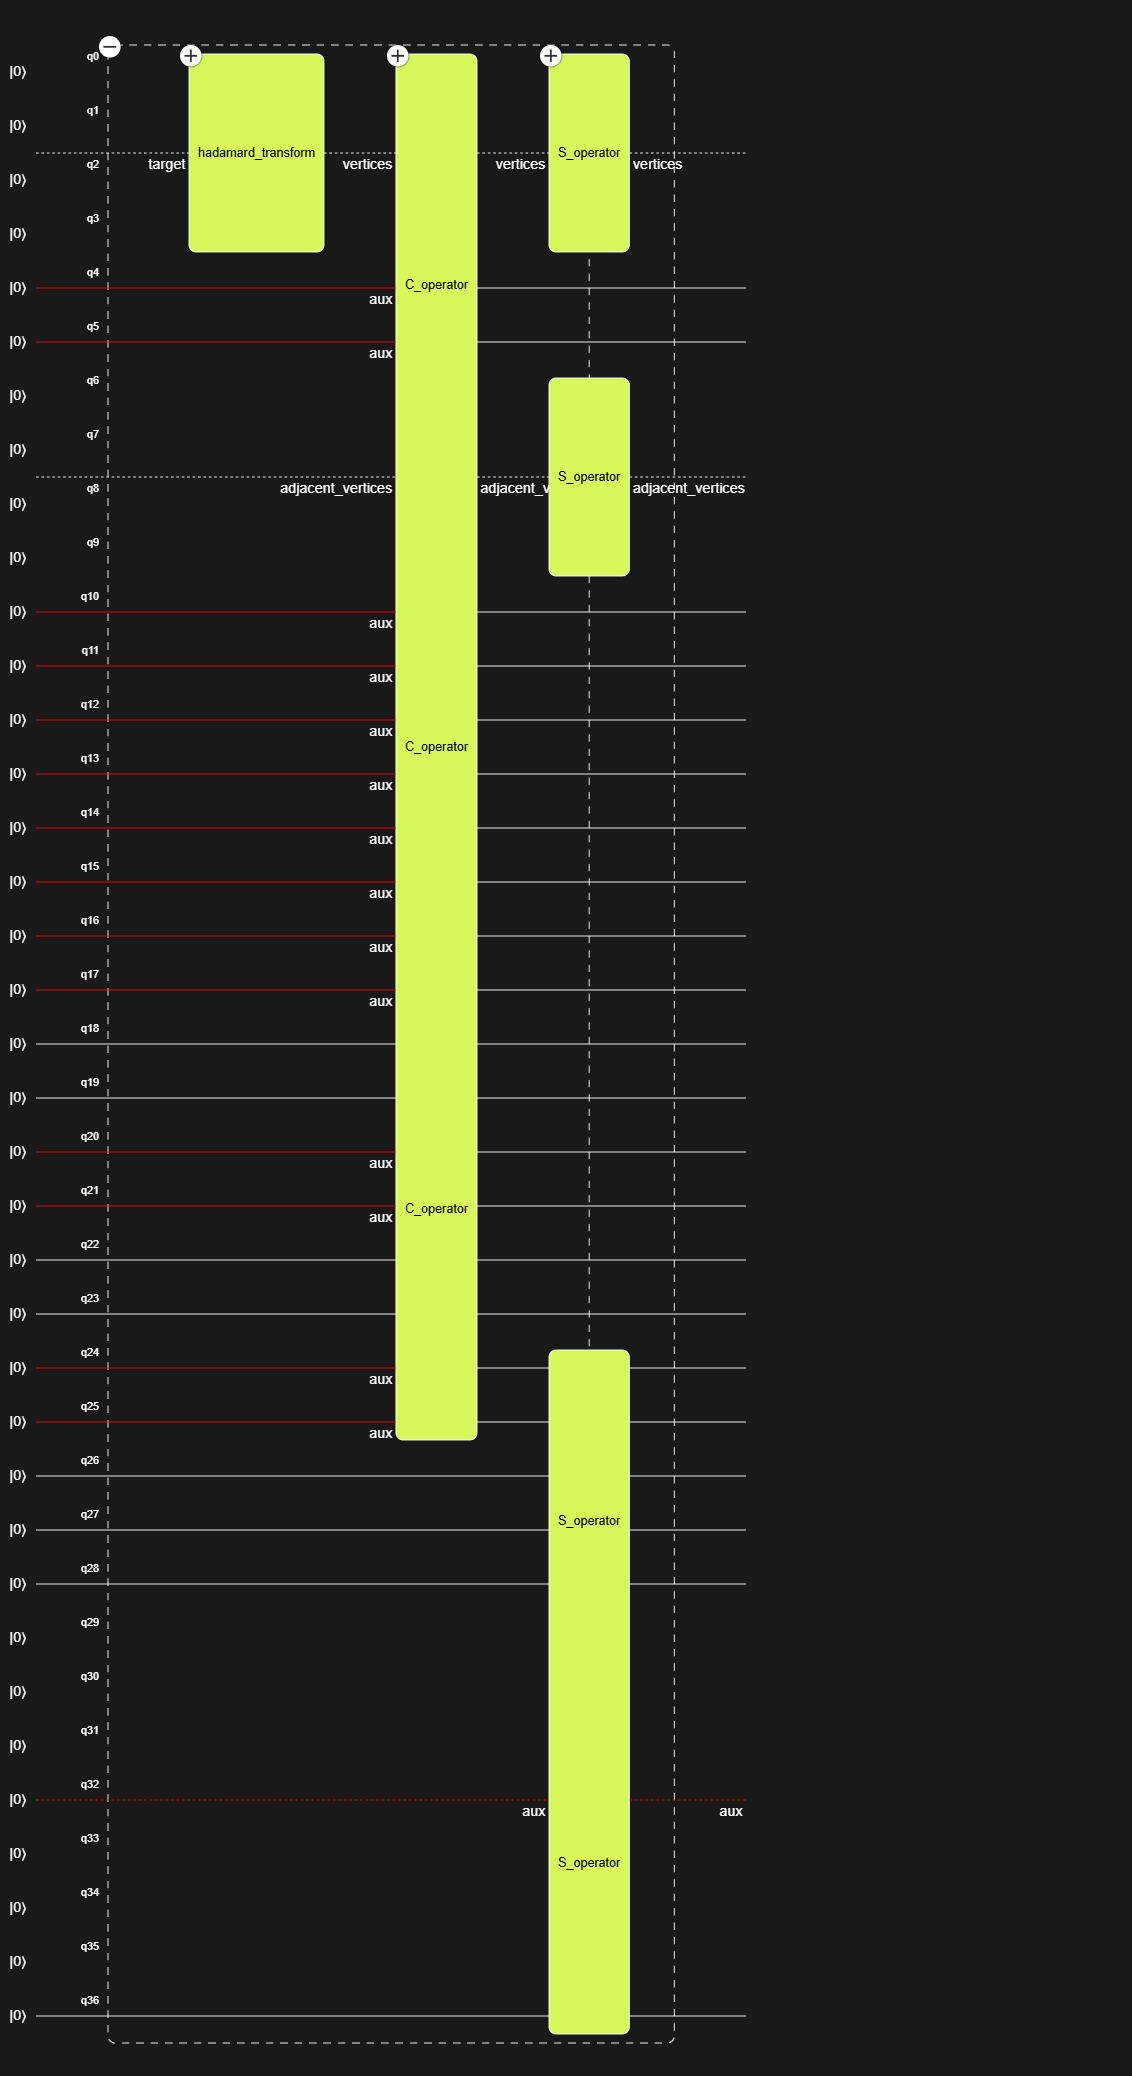